# Sparse sampling for self-energy

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as pl

pl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"})

In [4]:
try:
    import pyximport
    os.environ['CFLAGS'] = os.environ.get('CFLAGS','') + ' -fopenmp'
    os.environ['LDFLAGS'] = os.environ.get('LDFLAGS','') + ' -fopenmp'
    pyximport.install(setup_args={
        'include_dirs': np.get_include()
        })
except ImportError:
    pass

In [5]:
import irbasis
import irbasis_x
from irbasis_x import _aux
from irbasis_x import freq
from irbasis_x import atom
from irbasis_x import fourpoint
from irbasis_x import twopoint
from irbasis_x import quad

IR basis infrastructure

In [6]:
#cutoff = 1e-7
wmax = 1.0
beta = 10.0
lambda_ = wmax * beta

In [7]:
b_ = twopoint.VertexBasis(irbasis.load('F', lambda_))
b = twopoint.FiniteTemperatureBasis(b_, beta)
b.dim()

20

We consider the self-energy given by
$$
\Sigma(i\omega_n) = \Sigma_0 + \frac{1}{i\omega-\epsilon_0},
$$
where $\epsilon_0 = 1/2$.

Sampling frequencies

In [8]:
wf_sp = b.sampling_points_matsubara(b.dim()-1)

Sl = b.Sl(None)
Unl = b.compute_Unl(wf_sp)

In [9]:
sigma_0 = 1
epsilon_0 = 0.5
sigma = lambda n: sigma_0 + 1/(1J*(2*n+1)*np.pi/beta - epsilon_0)

In [10]:
y_sp = sigma(wf_sp)
gl = np.linalg.lstsq(Unl, sigma(y_sp), rcond=None)[0]

''

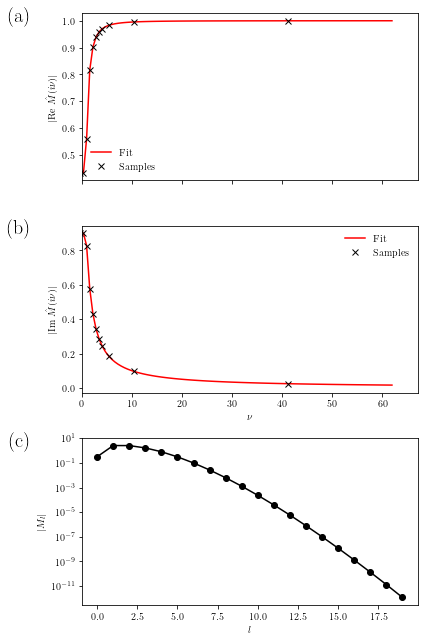

In [11]:
fig = pl.figure(figsize=(6,9))
ax1 = pl.subplot(311)
ax2 = pl.subplot(312, sharex = ax1)
ax3 = pl.subplot(313)

axes = [ax1, ax2, ax3]

x_test = np.arange(1.5*np.amax(wf_sp)+1)
y_fit = sigma(x_test)
ax1.plot((2*x_test+1)*np.pi/beta, np.abs(y_fit.real), marker='', label=r'$\mathrm{Fit}$', c='r')
ax1.plot((2*wf_sp+1)*np.pi/beta, np.abs(y_sp.real), marker='x', ls='', label=r'$\mathrm{Samples}$', c='k')
ax1.legend(frameon=False)

ax2.plot((2*x_test+1)*np.pi/beta, np.abs(y_fit.imag), marker='', label=r'$\mathrm{Fit}$', c='r')
ax2.plot((2*wf_sp+1)*np.pi/beta, np.abs(y_sp.imag), marker='x', ls='', label=r'$\mathrm{Samples}$', c='k')
ax2.legend(frameon=False)

#ax3.semilogy(np.abs(rhol) * Sl, marker='o', c='k')
ax3.semilogy(np.abs(gl), marker='o', c='k')
#ax3.semilogy(Sl/Sl[0], marker='', ls='--', c='k')

#ax1.set_xscale('log')
ax1.set_xlim([0, None])
ax1.set_ylabel(r'$|\mathrm{Re}~\hat M(i\nu)|$')

pl.setp(ax1.get_xticklabels(), visible=False)

ax2.set_xlabel(r'$\nu$')
#ax2.set_xscale('log')
ax2.set_ylabel(r'$|\mathrm{Im}~\hat M(i\nu)|$')

ax3.set_xlabel(r'$l$')
ax3.set_yscale('log')
ax3.set_ylabel(r'$|M_l|$')

for ax, label in zip(axes, ['a', 'b', 'c']):
    ax.text(-0.15, 1.04, r'$\mathrm{(' + label + r')}$', transform=ax.transAxes,
             fontsize=20, fontweight='bold', va='top', ha='right')

pl.tight_layout()
pl.savefig('sparse_sampling.pdf', transparent=True)
;